In [30]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.stride_tricks import as_strided

from sklearn.model_selection import train_test_split, GridSearchCV

# from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
# from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

## Read Dataset

In [2]:
fname = 'GuangzhouPM20100101_20151231.csv'
usecols = np.array(['HUMI', 'PRES', 'Iws', 'Iprec', 'PM_US_Post'])
labels = np.array([0, 1, 2])
    
rec_raw = np.genfromtxt(fname,
                delimiter=',',
                names=True,
                dtype=np.float64,
                usecols=usecols,
                )

rec_raw.shape

(52584,)

## Covent Label

In [3]:
rec = rec_raw.copy()

rec['PM_US_Post'][rec['PM_US_Post'] < 10] = labels[0]
rec['PM_US_Post'][(rec['PM_US_Post'] <= 25) & (rec['PM_US_Post'] >= 10)] = labels[1]
rec['PM_US_Post'][rec['PM_US_Post'] > 25] = labels[2]

rec.shape

(52584,)

## Visualization

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


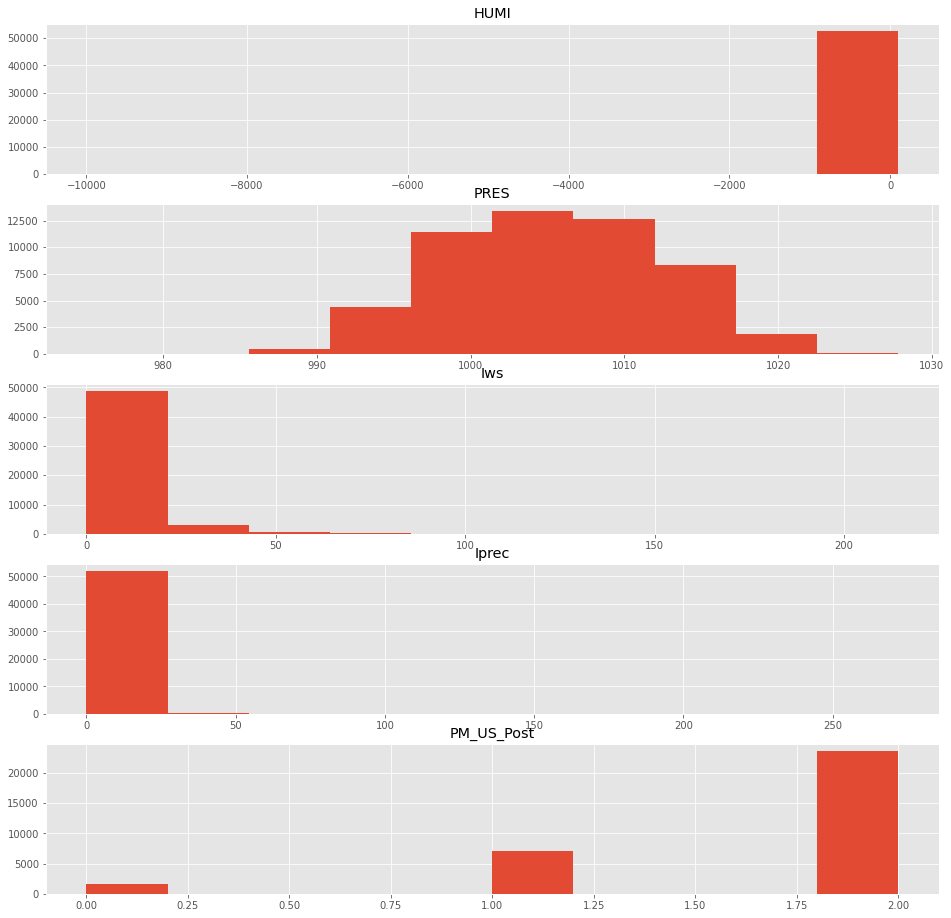

In [4]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec.dtype.names):
    ax[i].hist(rec[col])
    ax[i].set_title(col)

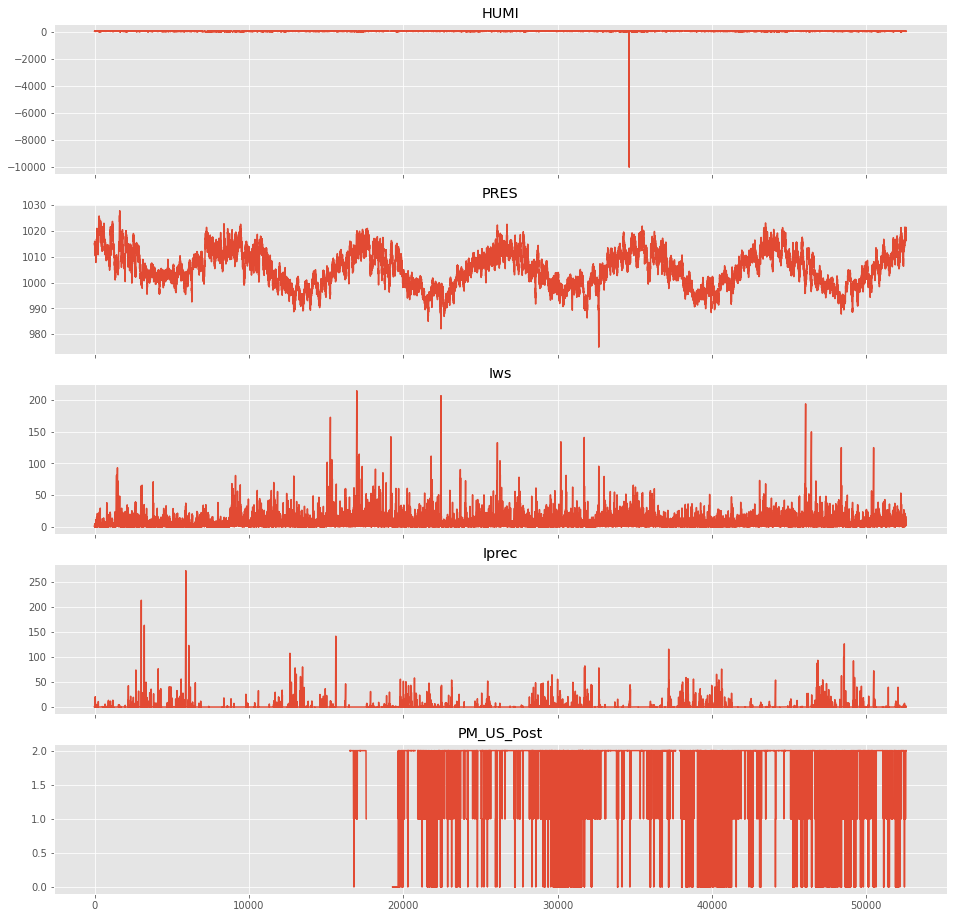

In [5]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot(rec[col])
    ax[i].set_title(col)

In [6]:
# import pandas as pd
# import seaborn as sns

# df = pd.DataFrame(rec)
# g = sns.PairGrid(df)
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.distplot)

## Count Label

In [28]:
unique, counts = np.unique(rec['PM_US_Post'], return_counts=True)

dict(zip(unique, counts))

{0.0: 1581, 1.0: 7076, 2.0: 23488}

## Drop Duplicate

In [7]:
rec = np.unique(rec, axis=0)

rec.shape

(52377,)

## Drop Label NaN

In [8]:
rec = rec[~np.isnan(rec['PM_US_Post'])]

rec.shape

(32145,)

## Show NaN row

In [9]:
view = rec.view(np.float64).reshape(-1, rec.dtype.__len__())

rec[np.any(np.isnan(view), axis=1)]

array([(nan, nan, nan, nan, 2.)],
      dtype=[('HUMI', '<f8'), ('PRES', '<f8'), ('Iws', '<f8'), ('Iprec', '<f8'), ('PM_US_Post', '<f8')])

## Interpolation

In [10]:
for i, col in enumerate(rec.dtype.names[:-1]):
    indices = np.arange(rec[col].shape[0])
    not_nan = ~np.isnan(rec[col])
    rec[col] = np.interp(indices, indices[not_nan], rec[col][not_nan])

## Moving Average

In [11]:
for i, col in enumerate(rec.dtype.names[:-1]):
    rec[col] = np.convolve(rec[col], np.ones(4)/4, mode='same')

## Visualization

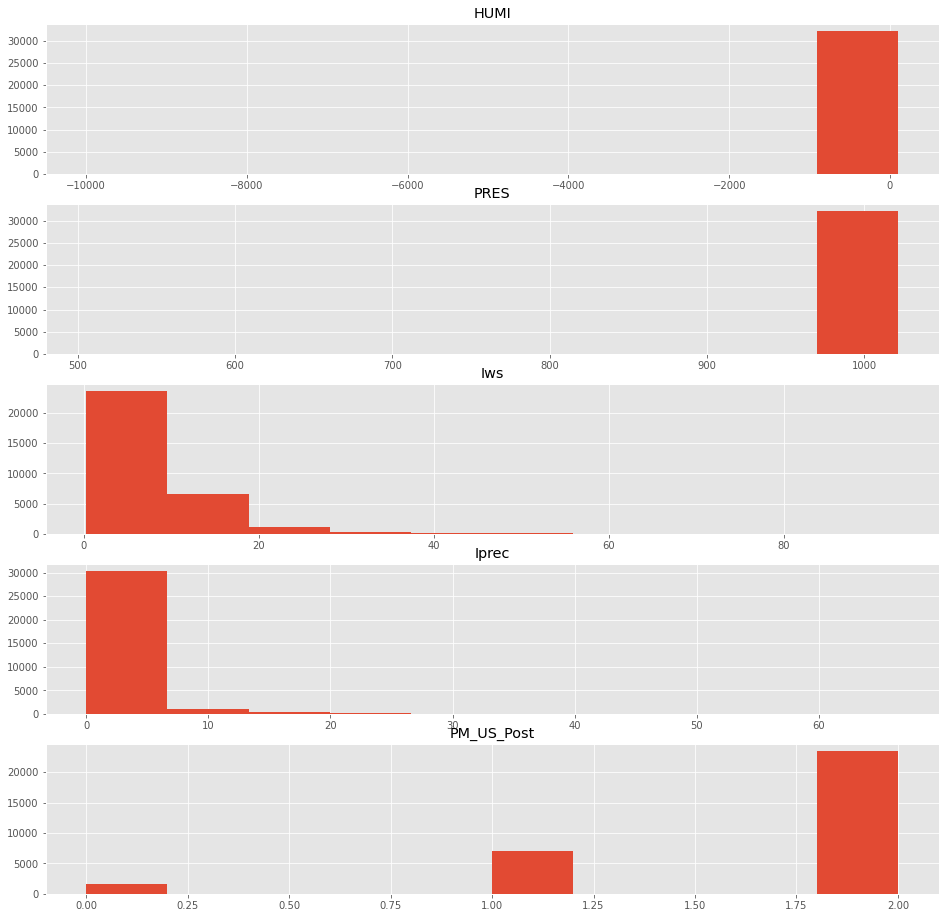

In [12]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec.dtype.names):
    ax[i].hist(rec[col])
    ax[i].set_title(col)

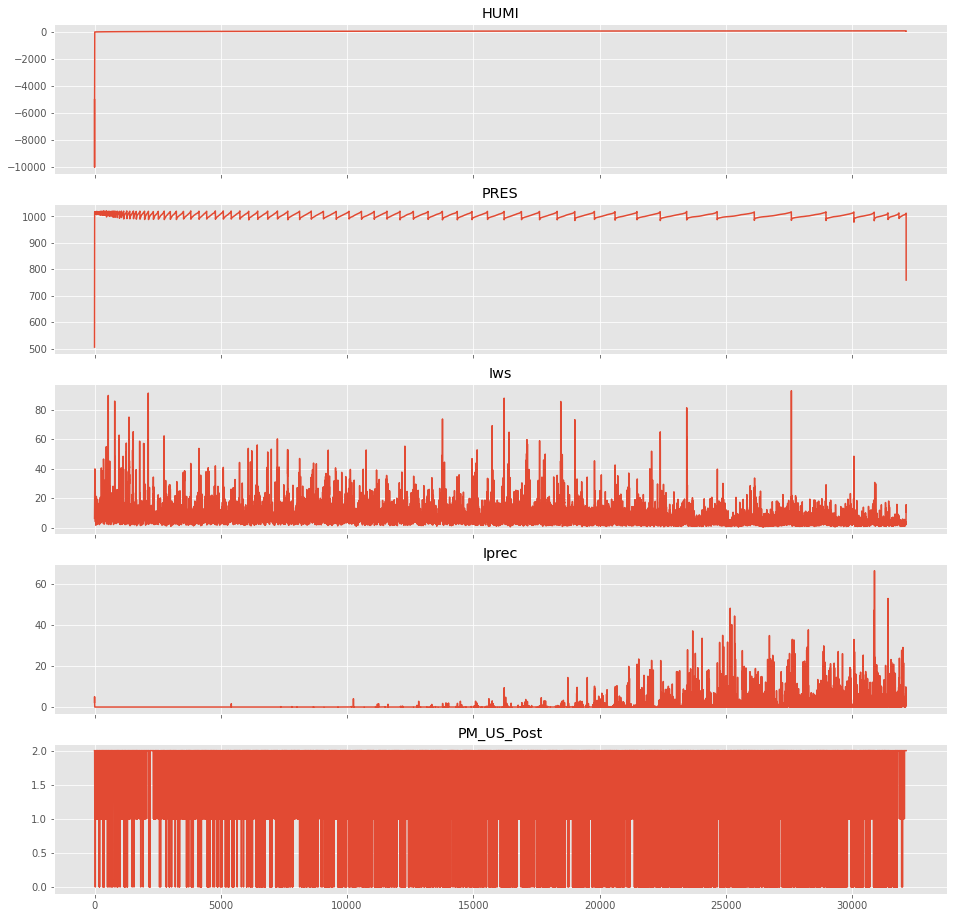

In [13]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot(rec[col])
    ax[i].set_title(col)

In [14]:
# df = pd.DataFrame(rec)
# g = sns.PairGrid(df)
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.distplot)

## Standardization Normalization

In [15]:
rec_norm = rec.copy()

for i, col in enumerate(rec_norm.dtype.names[:-1]):
    rec_norm[col] = (rec_norm[col] - rec_norm[col].mean()) / rec_norm[col].std()


## Covent Time-series format

In [16]:
def create_strided(rec, feature, step, windows):
    colsize = rec[0].__len__() +1
    itemsize = np.dtype(np.float64).itemsize
    shape = (rec.shape[0]//step, windows)
    strides = (step*colsize*itemsize, colsize*itemsize)

    rec_windows = as_strided(rec, shape=shape, strides=strides)
    return rec_windows

In [17]:
step = 20
windows = 100

rec_windows = []
rec_labels = []
for label in labels:
    j = create_strided(rec[rec['PM_US_Post'] == label], label, step, windows)
    rec_windows.append(j)
    rec_labels.append(np.repeat(label, j.shape[0]))

rec_windows = np.concatenate(rec_windows)
rec_labels = np.concatenate(rec_labels)

rec.shape, rec_windows.shape, rec_labels.shape

((32145,), (1606, 100), (1606,))

## One-Hot Encoder

In [18]:
one_hot = np.zeros((rec_labels.shape[0], 1, labels.shape[0]))
for i, unique_value in enumerate(labels):
    one_hot[:, :, i][rec_labels == unique_value] = 1

rec_labels_onehot = one_hot.reshape(-1, labels.shape[0]*1)

rec_labels_onehot.shape

(1606, 3)

## Train & Test Split

In [19]:
random_state = 0

# np.random.seed(random_state)
# np.random.shuffle(rec_windows)

# np.random.seed(random_state)
# np.random.shuffle(rec_labels_onehot)

# rec_windows.shape, rec_labels_onehot.shape

((1606, 100), (1606, 3))

In [20]:
train_size = 0.8
# Implement stratified samples
# sample = int(train_size*rec_labels_onehot.shape[0])

# X_train, X_test = rec_windows[:sample], rec_windows[sample:]
# y_train, y_test = rec_labels_onehot[:sample], rec_labels_onehot[sample:]

# X_train.shape, X_test.shape

((1284, 100), (322, 100))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(rec_windows, rec_labels_onehot, test_size=1 -train_size, random_state=random_state, stratify=rec_labels_onehot)

## CNN Model